# Time series forecasting with python
This repository tries to encapsulate the basics of time series forecasting. I will talk through the basics of time series analysis and give an overview of the most efective methods I have encountered for both Univariate and Multivariate series.


  



**Why this repository?**

A lof of github repositories for time series forecasting use dummy series with strong and unrealistic features to showcase different models. This repository tries to give a more real use scenario on how to approach time series forecasting.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
import gluonts
from math import sqrt

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones

from utils.metrics import evaluate
from utils.plots import bar_metrics

from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization


#Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
INFO:root:Using CPU


2.0.0


# The dataset

The dataset used is the [Beijing air quality](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data) public dataset. This dataset contains polution data from 2014 to 2019 sampled every 10 minutes along with extra weather features such as preassure, temperature etc. We decided to resample the dataset with daily frequency for both easier data handling and proximity to a real use case scenario (no one would build a model to predict polution 10 minutes ahead, 1 day ahead looks more realistic). 

In order to obtain a exact copy of the dataset used in this tutorial please run the [script](https://github.com/jiwidi/time-series-forecasting-wiki/blob/master/datasets/download_datasets.py) under `datasets/download_datasets.py` which will automatically download the dataset and preprocess it for you.




In [2]:
#Execute the script to download and process the dataset by running this cell
!python3 datasets/download_datasets.py

INFO:__main__:Processing air pollution dataset
/usr/local/lib/python3.6/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
INFO:__main__:Saving air pollution dataset to/Users/jaime/Documents/Github/time-series-forecasting-wiki/datasets
INFO:__main__:Air pollution dataset processed
INFO:__main__:Processing done


## Load the dataset and quick preview

In [3]:
air_pollution = pd.read_csv('datasets/air_pollution.csv',parse_dates=['date'])
air_pollution.set_index('date',inplace=True)
air_pollution.head() #

pollution_today        dew       temp        press     wnd_spd  \
date                                                                         
2010-01-02       145.958333  -8.500000  -5.125000  1024.750000   24.860000   
2010-01-03        78.833333 -10.125000  -8.541667  1022.791667   70.937917   
2010-01-04        31.333333 -20.875000 -11.500000  1029.291667  111.160833   
2010-01-05        42.458333 -24.583333 -14.458333  1033.625000   56.920000   
2010-01-06        56.416667 -23.708333 -12.541667  1033.750000   18.511667   

                 snow  rain  pollution_yesterday  
date                                              
2010-01-02   0.708333   0.0            10.041667  
2010-01-03  14.166667   0.0           145.958333  
2010-01-04   0.000000   0.0            78.833333  
2010-01-05   0.000000   0.0            31.333333  
2010-01-06   0.000000   0.0            42.458333

In [4]:
air_pollution.describe()

pollution_today          dew         temp        press      wnd_spd  \
count      1825.000000  1825.000000  1825.000000  1825.000000  1825.000000   
mean         98.245080     1.828516    12.459041  1016.447306    23.894307   
std          76.807697    14.163508    11.552997    10.076053    41.373161   
min           3.166667   -33.333333   -14.458333   994.041667     1.412500   
25%          42.333333   -10.083333     1.541667  1007.916667     5.904167   
50%          79.166667     2.041667    13.916667  1016.208333    10.953750   
75%         131.166667    15.083333    23.166667  1024.541667    22.235000   
max         541.895833    26.208333    32.875000  1043.458333   463.187917   

              snow         rain  pollution_yesterday  
count  1825.000000  1825.000000          1825.000000  
mean      0.052763     0.195023            98.245080  
std       0.546072     0.993917            76.807697  
min       0.000000     0.000000             3.166667  
25%       0.000000     0.000000            42.333333  
50%       0.000000     0.000000            79.166667  
75%       0.000000     0.000000           131.166667  
max      14.166667    17.583333           541.895833

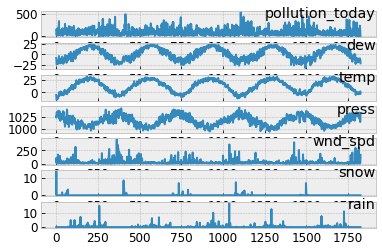

In [5]:
values = air_pollution.values
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(air_pollution.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

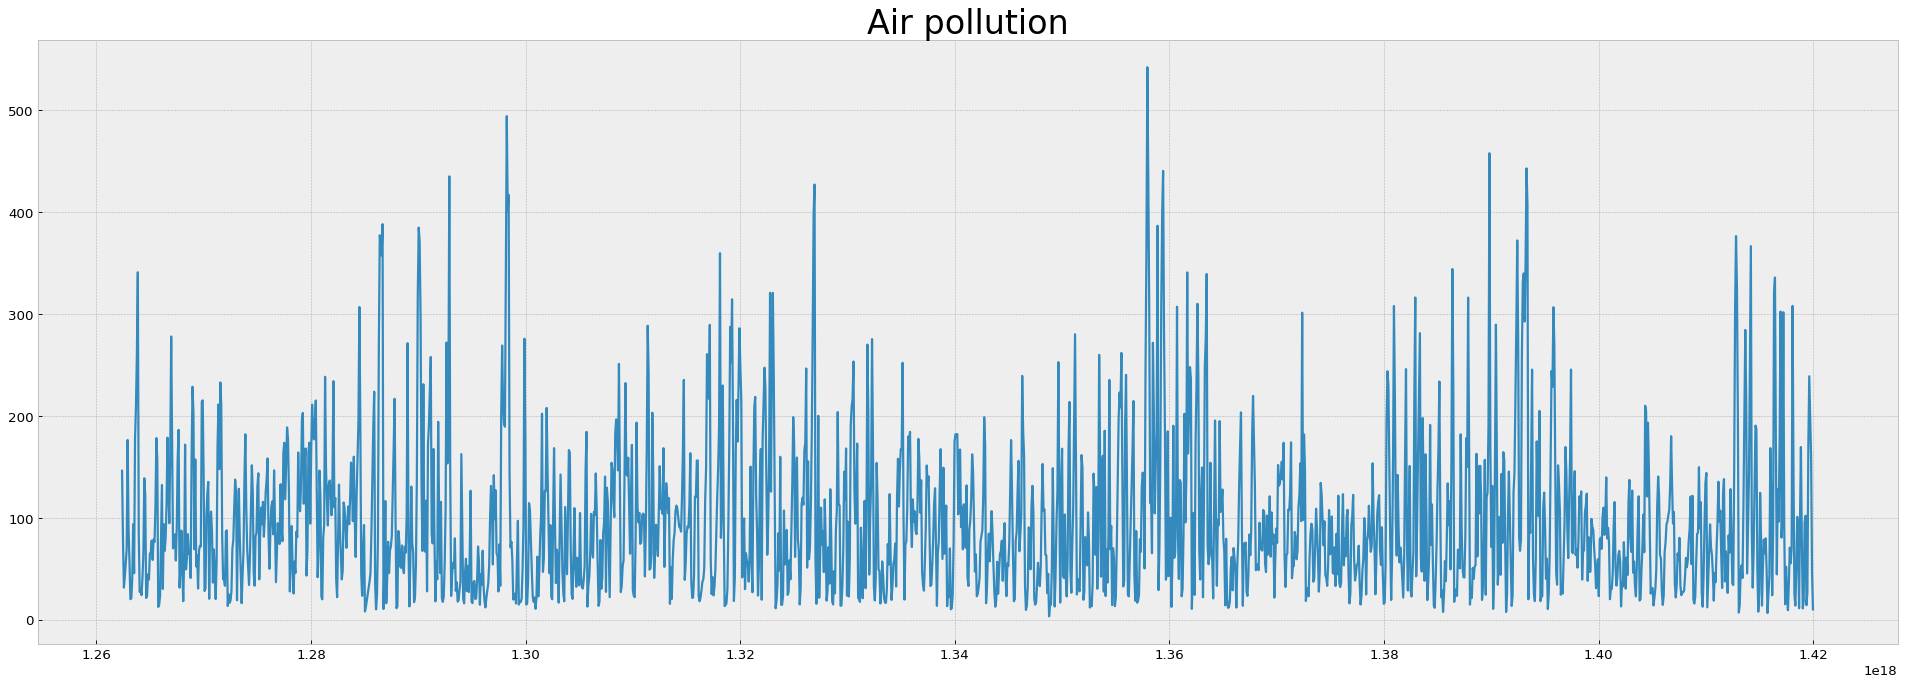

In [6]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution',fontsize=30)

plt.plot(air_pollution.pollution_today)
plt.savefig("results/pollution.png")

# Time series analysis and transforms

## Decomposing our time series

One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present (there will be more analysis for this two parts).

This 4 parts can combine either additively or multiplicatively into the time series.

##### Additive Model
`y(t) = Level + Trend + Seasonality + Noise`

Additives models are lineal. Trend is linear and seasonality has constant frequency and amplitude. Change is constant over time
   
##### Multiplicative model
`y(t) = Level * Trend * Seasonality * Noise`

Multiplicatives models are nonlinear,trend is curved and seasonality is not constant. Change is not constant over time

Decomposing is used to analyse the time series. Identify each one of the different parts of the time series and its behaviour, each of the components may affect your models in different ways. 

Most time series are a combination of a additive model and a multiplicate model, is hard to identify real world time series into one single model. 

##### Automatic time series decomposition

Statsmodel python library provides a function [seasonal_compose()](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to automatically decompose a time series, you still need to specify wether the model is additive or multiplicative. We will use multiplicative as our quick peak at the pm2.5 time series shows no linear trend.

<Figure size 4000x1600 with 0 Axes>

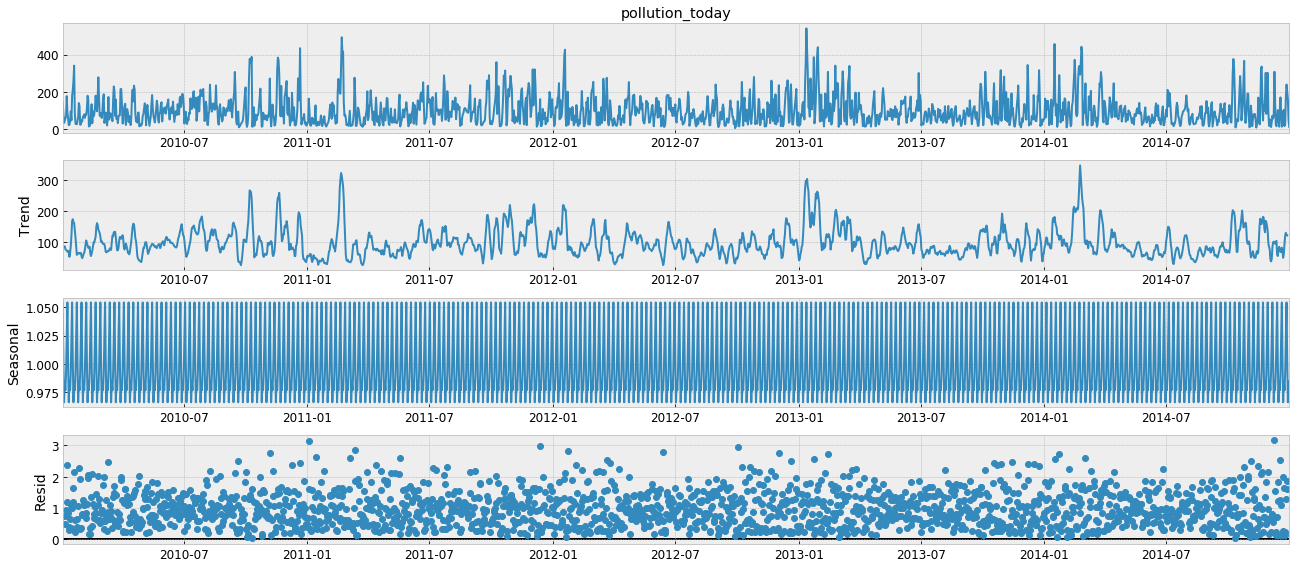

In [7]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

### Level

Level simply means the current value of the series once we remove trend, seasonality and the random noise. This are the true values that come from the series itself and we will try to predict with our models. Most of the models will benefit the more our time series is composed by the level and not trends/seasonality/noise. We also present models capable of handling seasonality and trend (non stationary series)

### Trend

A trend is observed when there is an increasing or decreasing slope observed in the time series. A trend is a smooth, general, long-term, average tendency. It is not always necessary that the increase or decrease is in the same direction throughout the given period of time. 

Trend can be removed from your time series data (and data in the future) as a data preparation and cleaning exercise. This is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models. We will see different methods for this in the making your series stationary section

In practice, identifying a trend in a time series can be a subjective process as we are never sure if contains seasonalities or noise to it, 
Create line plots of your data and inspect the plots for obvious trends.

Now we will try some methods to check for trend in our series:
* Automatic decomposing
* Moving average
* Fit a linear regression model to identify trend



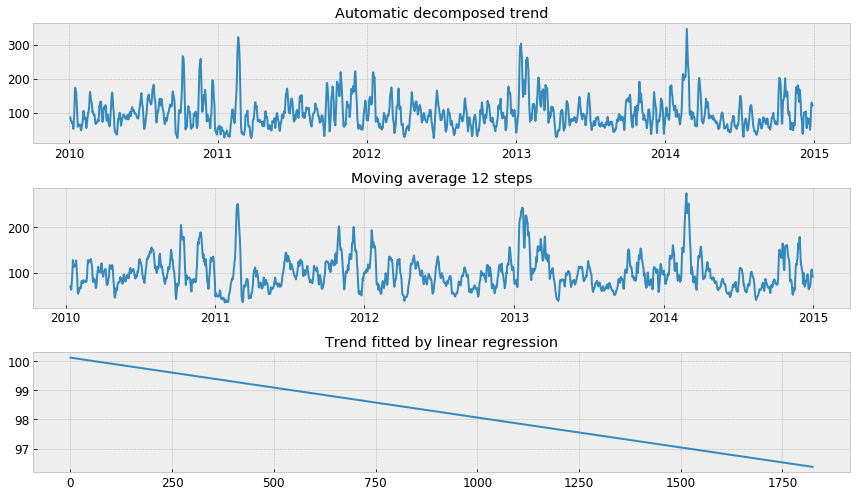

In [8]:
fig = plt.figure(figsize=(12, 7))
layout = (3,2)
pm_ax = plt.subplot2grid(layout, (0,0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1,0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2,0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = air_pollution.pollution_today.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(air_pollution.pollution_today))]
X = np.reshape(X, (len(X), 1))
y = air_pollution.pollution_today.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

We can see our series does not have a strong trend, results from both the automatic decomposition and the moving average look more like a seasonality efect+random noise than a trend. This sort of confirmed with our linear regression, which cant find our series properly and gives us a poor trend.

We could also try to split our series into smaller ones to try identify subtrends with the mentioned methods but we will not be doing so in this section.

### Seasonality
Seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day. For example the amount of sunscream protector (always low in winter and high in summer).

The automatic decomposing chart did not gave us a good look into the decomposed seasonality, let's try decomposing smaller parts of the time series first and test seasonalities we found into the others.

Lets go with the first year of data only now:

<Figure size 4000x1600 with 0 Axes>

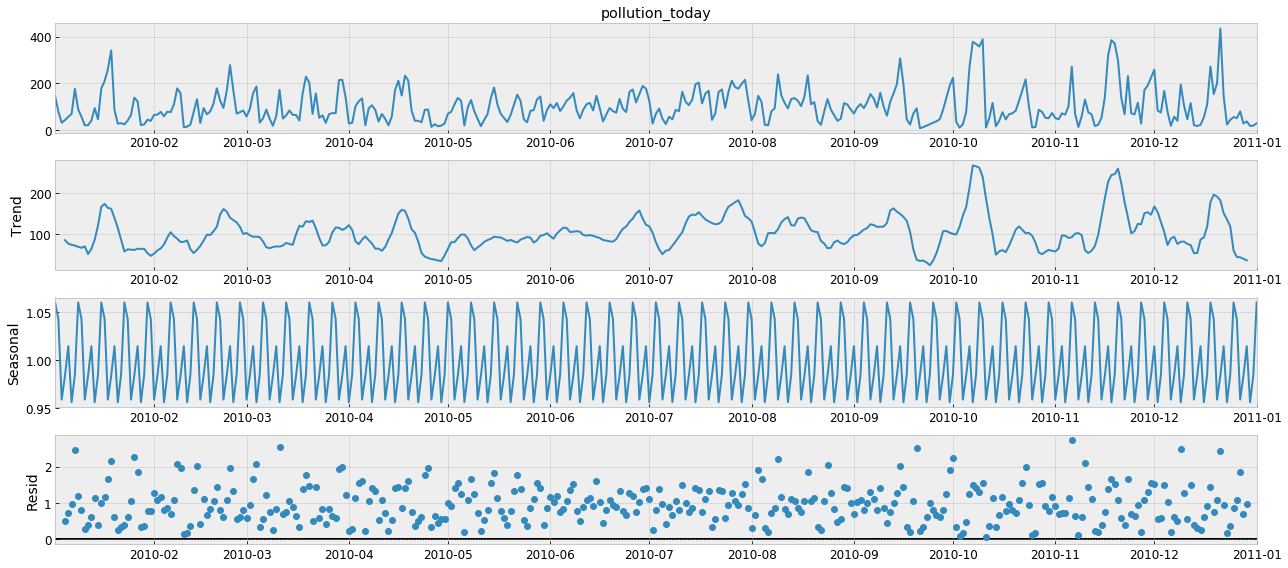

In [9]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

Here can see a clear weekly trend, 4 spikes every month (weerkly). Lets check how the last year of data looks

<Figure size 4000x1600 with 0 Axes>

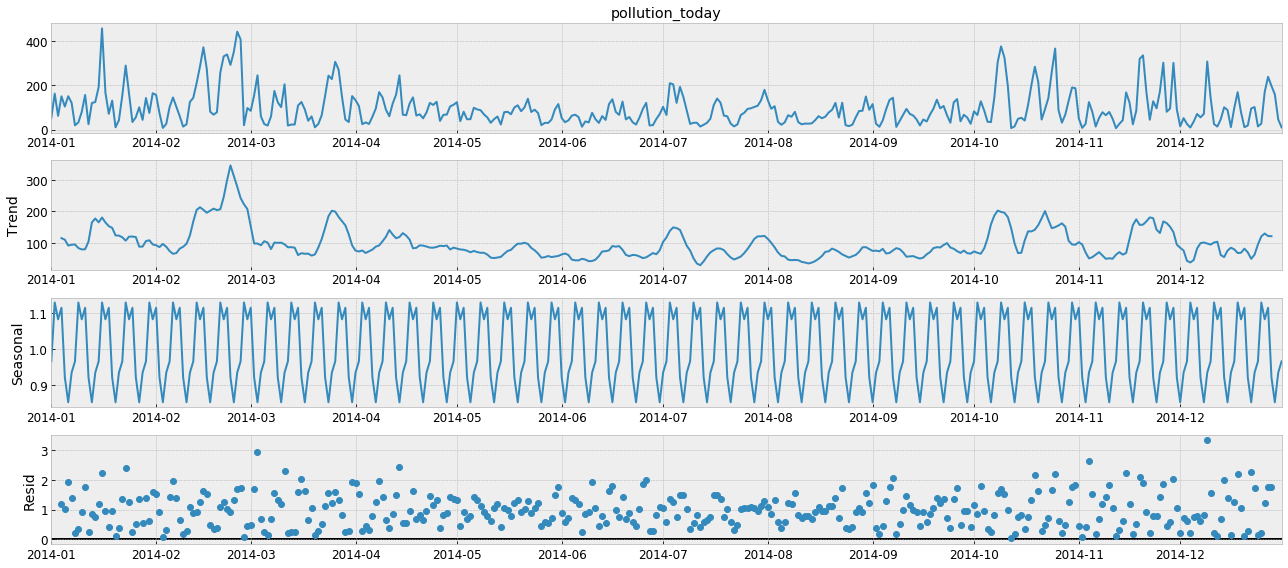

In [10]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[-365:]
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

We see another weekly seasonality(4 spikes between every month) but a bit different to the original one, this is something we should always expect from real datasets as their seasonalities will never be perfect but a combination of multiples.

##INTERPRETATION

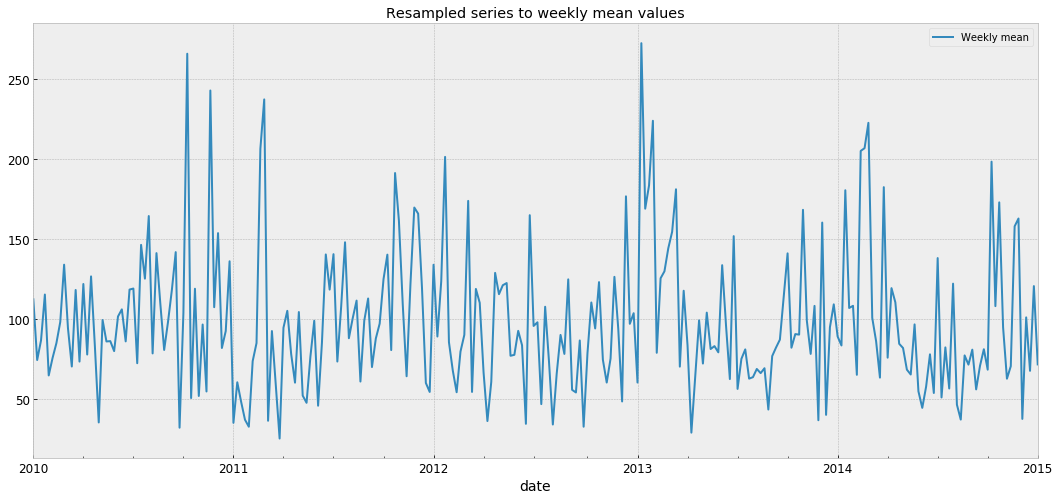

In [11]:
#Looking for weekly seasonality
resample = air_pollution.resample('W')
weekly_mean = resample.mean()
weekly_mean.pollution_today.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

**Manual methods to find seasonalities**

We can also try to generate a model to find the seasonalities for us. One of the most common to use is a simple polynomial model.

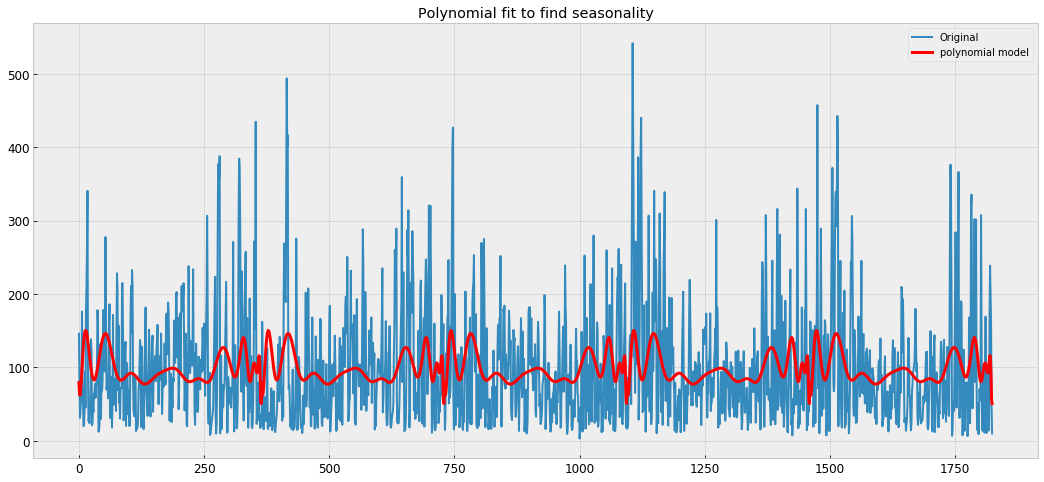

In [12]:
#Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = air_pollution.pollution_today.values
X = [i%365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series,label='Original')
plt.plot(curve, color='red', linewidth=3,label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

We can see how the model to find a seasonality fits poorly to our data. Is going to be a complicate time series to model :P 

### Noise

Our time series will also have a noise component to them, most likely [white noise](https://en.wikipedia.org/wiki/White_noise). We say white noise is present if the measurement are independent and identically distributed with a mean of zero. This will mean all our measurements have same variance and no correlation with the rest of values in the series. 

If our time series has white noise this will mean we can't predict that component of the series (as is random) and we shoul aim to produce a model with errors close to this white noise.

How to check if our series has white noise?
* Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std 
* Correlation plots
* Standard deviation distribution, is it a Gaussian distribution?
* Does the mean or level change over time?

Text(0.5, 1.0, 'Mean over time')

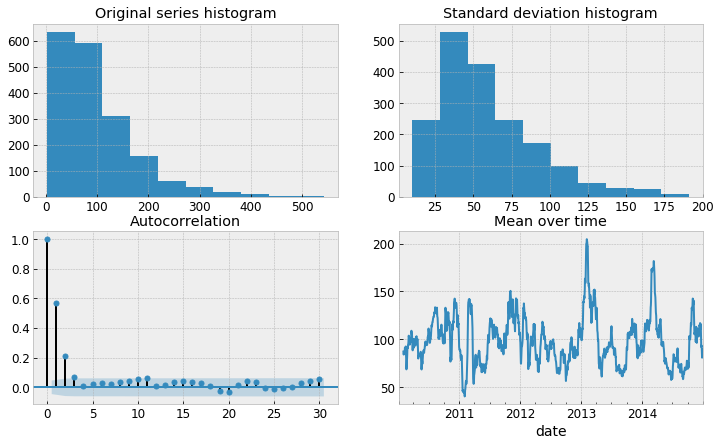

In [13]:
fig = plt.figure(figsize=(12, 7))
layout = (2,2)
hist_ax = plt.subplot2grid(layout, (0,0))
ac_ax = plt.subplot2grid(layout, (1,0))
hist_std_ax = plt.subplot2grid(layout, (0,1))
mean_ax = plt.subplot2grid(layout, (1,1))

air_pollution.pollution_today.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags = 30,ax = ac_ax)
ac_ax.set_title("Autocorrelation")

mm = air_pollution.pollution_today.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = air_pollution.pollution_today.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")


We can see our series do not follow a Gaussian distribution from the histogram and neither the standard deviation, thought the std does has the mean more centered which shows a small part of white noise that is not possible to split from the original series (this will happen most of the times, specially is real life datasets)). 

We also have a small correlation with close measurements in time but not present with distant measurements (this could also indicate low seasonality). The mean over time also shows something similar with a constant value and high peaks in the same moments for the 4 years (smaller in 2012)

We could say our series does contain a small part of white noise but it is really small and hard to remove

## Stationarity
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

### Check for sationarity




### Autocorrelation and Partial autocorrelation plots

Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.



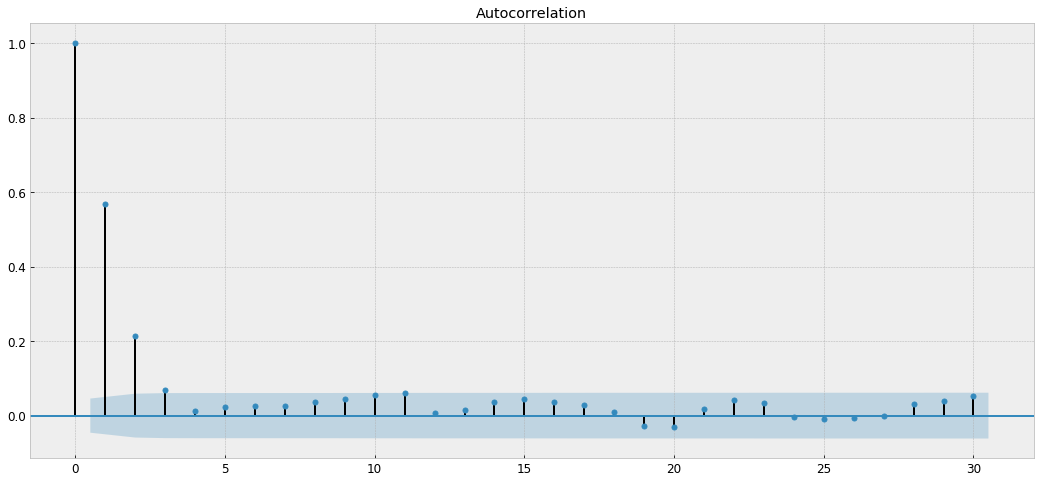

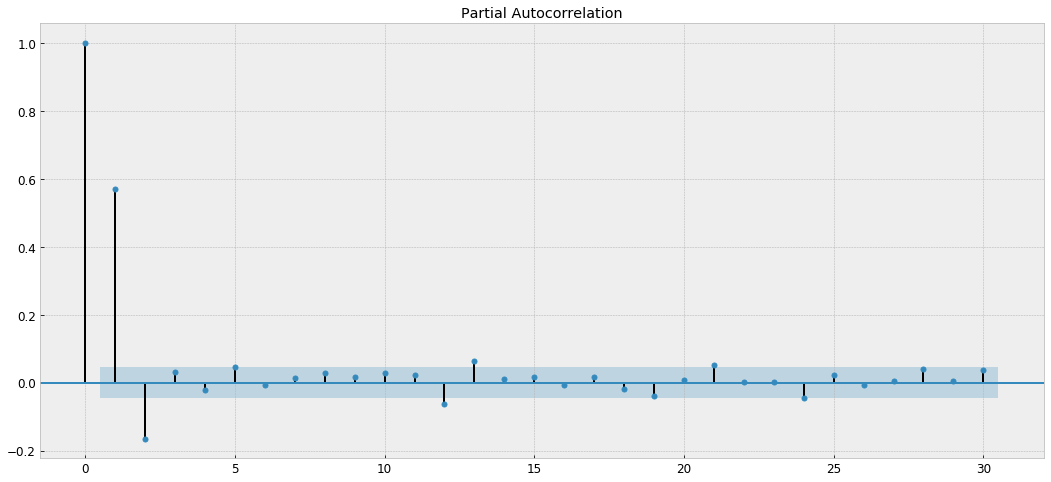

In [14]:
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

We saw that our time series values are not correlated with distant points in time, this is good and shows us our series should be stationary but for the shake of learning and confirming we will test with some other methods

### Rolling means and standard deviation of our series

We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series, why not just plot this two properties?

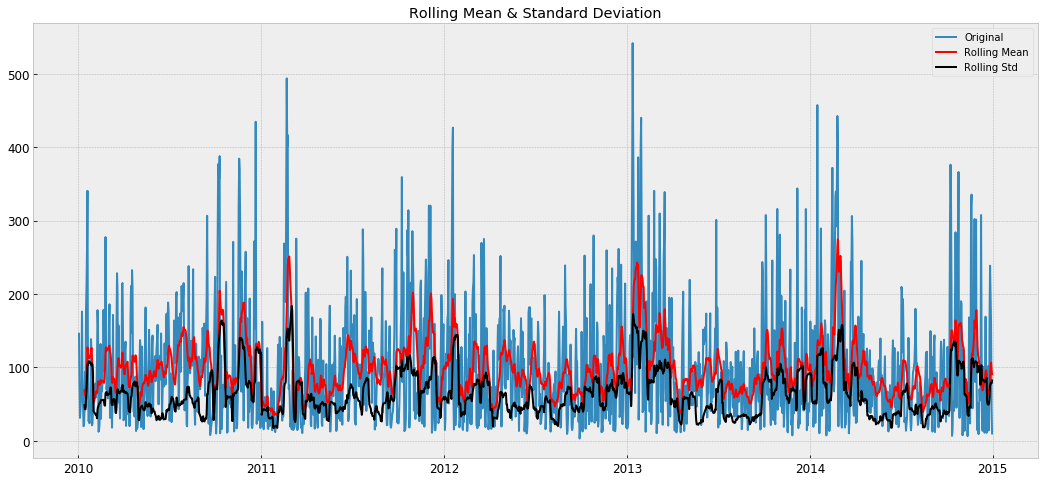

In [15]:
#Determing rolling statistics
rolmean = air_pollution.pollution_today.rolling(window=12).mean()
rolstd = air_pollution.pollution_today.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(air_pollution.pollution_today,label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

We can see how our mean and standar deviation have a constant behaviour over the years, even if they change over the year this behaviour is then repeated next year. This proves us again a stationary series

### Augmented Dickey-Fuller test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.


In [16]:
X = air_pollution.pollution_today.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.116719
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Here we also provide a method to quickly perform all the previous methods into one single function call and a pretty graph :) 

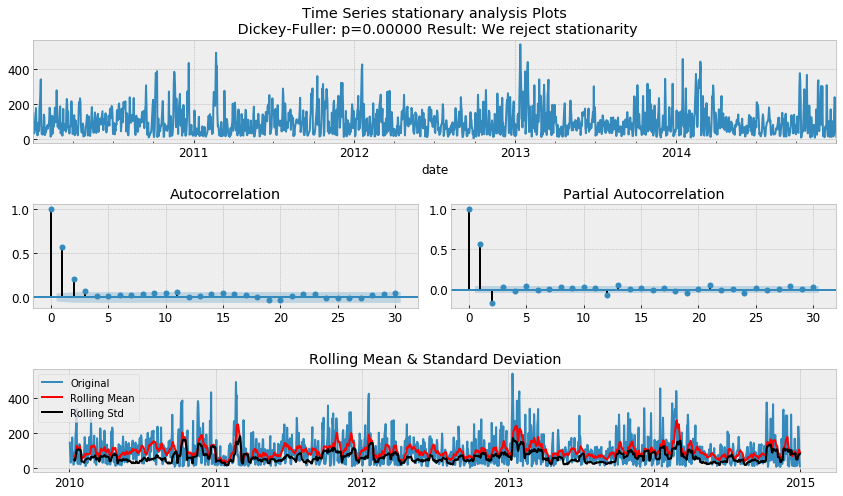

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        mean_std_ax = plt.subplot2grid(layout, (2,0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value<=0.05 else "We can not reject stationarity"
        ts_ax.set_title('Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value,hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
        rolmean = air_pollution.pollution_today.rolling(window=12).mean()
        rolstd = air_pollution.pollution_today.rolling(window=12).std()

        #Plot rolling statistics:
        orig = plt.plot(air_pollution.pollution_today,label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        
        
tsplot(air_pollution.pollution_today, lags=30)

## Making Time Series Stationary

Okay we got lucky with this dataset and is already stationary, but what happens when this is not the case? We included a dummy dataset called `international_airline_passengers.csv` on the datasets folders which is not stationary and we will apply some methods in this section to transform it into a stationary series.

Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

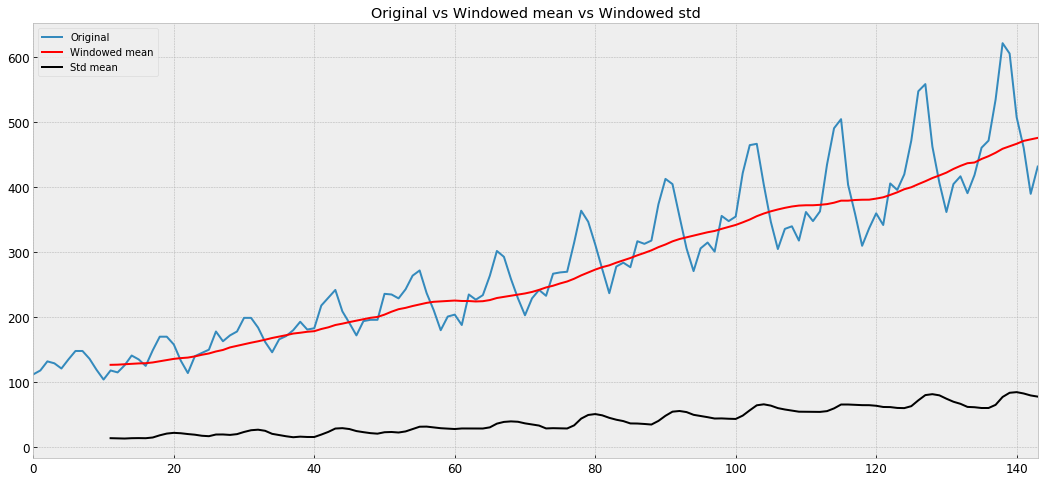

In [18]:
passengers = pd.read_csv("datasets/international_airline_passengers.csv")
passengers.passengers.plot(label='Original')
passengers.passengers.rolling(window=12).mean().plot(color='red', label='Windowed mean')
passengers.passengers.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Original vs Windowed mean vs Windowed std')

Lets run our stationary multitest function over this series

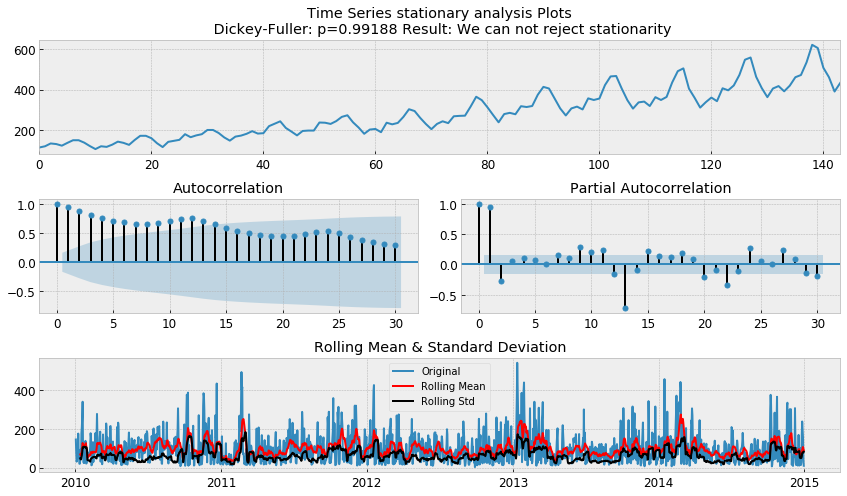

In [19]:
tsplot(passengers.passengers, lags=30)

With a p value of ~1 and high correlation values over time distant samples (showing a clear seasonality shape) we need to apply some methods to make the series stationary.

Coming back to the stationary definition, what makes our current series non stationary?

**Trend** - The mean for our series is not constant, it increases over time and 

**Seasonality** - The values of our series vary over time with an specific pattern that repeats over time, this is called seasonalities (spike of people flying on the 24th of December)

We now present some methods to remove or smotth this trend and seasonality components

### Difference transform

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`difference(t) = observation(t) - observation(t-1)`

Taking the difference between consecutive observations would be a lag-1 difference, we can tweek this lag value to fit our series.

We can also apply differencing transforms consecutively in the same series if the temporal effect hasnt been removed yet. This is called multiple order difference transform

In [20]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset=diff
    return diff

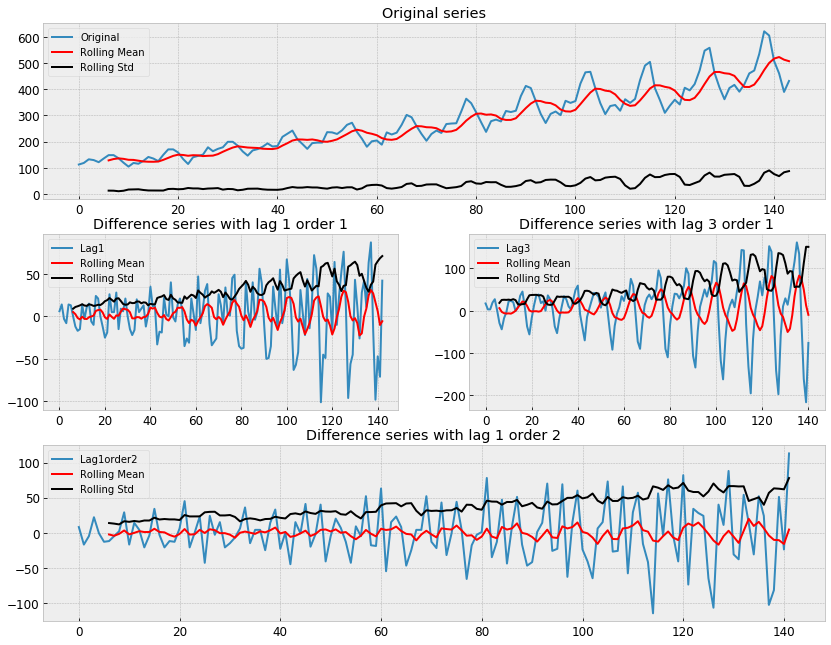

In [21]:
lag1series = pd.Series(difference(passengers.passengers, interval=1, order=1))
lag3series = pd.Series(difference(passengers.passengers, interval=3, order=1))
lag1order2series = pd.Series(difference(passengers.passengers, interval=1, order=2))

fig = plt.figure(figsize=(14,11))
layout = (3,2)
original = plt.subplot2grid(layout, (0,0), colspan=2)
lag1 = plt.subplot2grid(layout, (1,0))
lag3 = plt.subplot2grid(layout, (1,1))
lag1order2 = plt.subplot2grid(layout, (2,0), colspan=2)

original.set_title('Original series')
original.plot(passengers.passengers, label = 'Original')
original.plot(passengers.passengers.rolling(7).mean(), color='red', label='Rolling Mean')
original.plot(passengers.passengers.rolling(7).std(), color='black', label = 'Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label = "Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label = 'Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label = "Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label = 'Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label = "Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(), color='black', label = 'Rolling Std')
lag1order2.legend(loc='best')

We can see how 1 order differencing doesnt really remove stationary but once we go with a order 2 difference it looks closer to a stationary series

### Log scale transformation

Applying a log scale transform to a time series could also  help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`LogScaleTransform(t)= Log(t)`

Text(0.5, 1.0, 'Log scale transformation into original series')

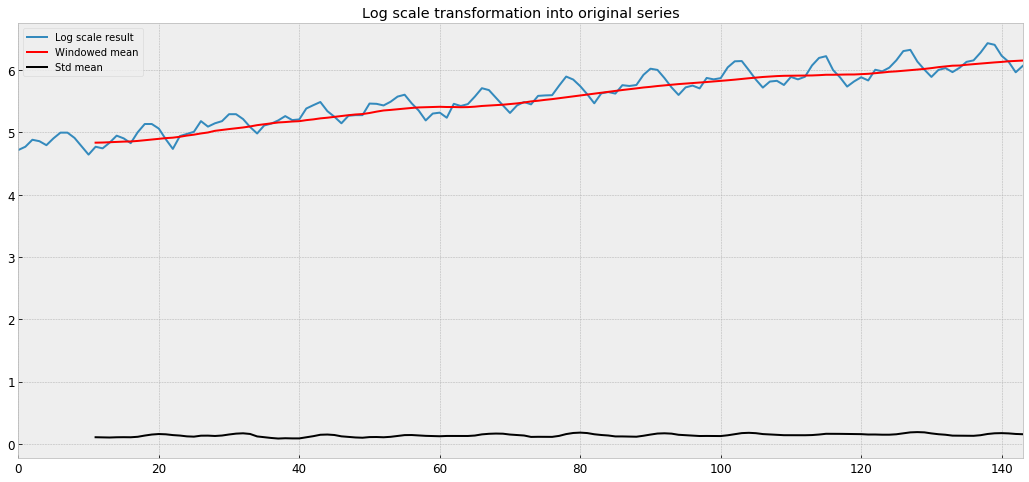

In [22]:
ts_log = np.log(passengers.passengers)
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

In [23]:
##COmment results

### Smoothing

We have seen the moving mean as a measure to check stationarity, we can also apply this windows to our series to remove seasonality.

With smotthing we will take rolling averages over periods of time. Is a bit tricky to choose the best windows #MORE ON THIS IN NEXT SECTION WITH AUTO WINDOWS

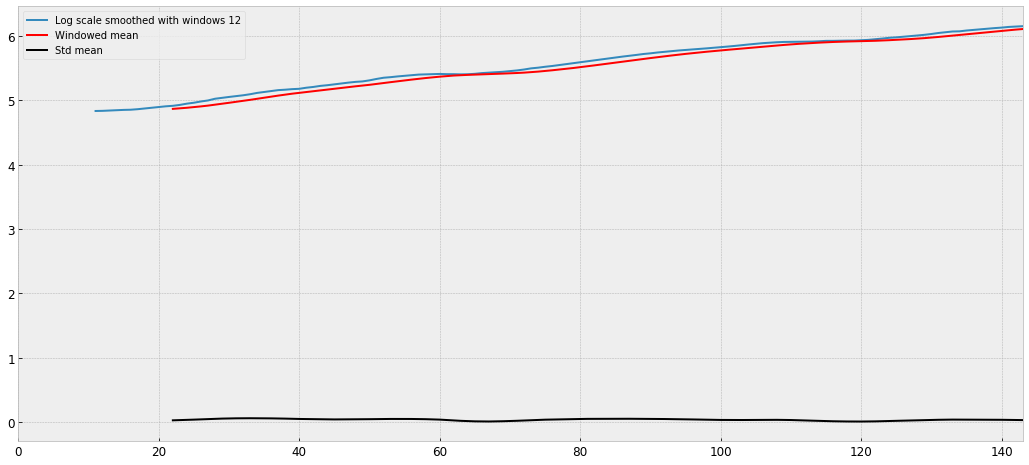

In [24]:
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()


We can combine it with our previous log scale and apply differencing

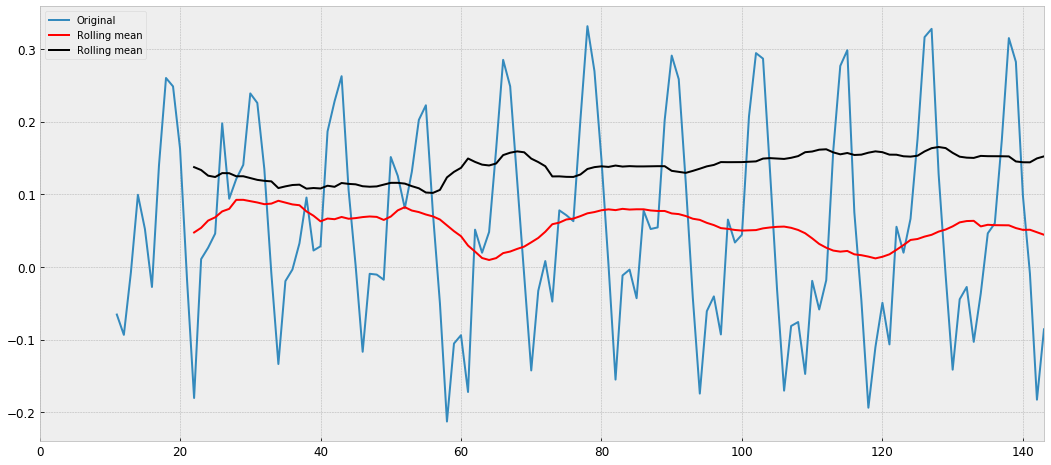

In [25]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(color='red',label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(color='black',label="Rolling mean")
plt.legend(loc='best')

# Methods for time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at your data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.

In this section we will show models for both cases, time series with and without extra regressors.

**Prepare data before modeling**

In [26]:
#We split our dataset to be able to evaluate our models

resultsDict={}
predictionsDict={}

split_date ='2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1461 days of training data 
 364 days of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

In [27]:
#Also add the naive mean average value
mean = df_test.pollution_today.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.pollution_today, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(df_test.pollution_today, df_test.pollution_yesterday)
predictionsDict['Yesterdays value'] = df_test.pollution_yesterday.values

## Univariate-time-series-forecasting

In this section we will focus on time series forecasting methods capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

### Autoregression (AR)
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. Parameters of the model:

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).


In [28]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = AR(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['Autoregression'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['Autoregression'] = yhat.values

100%|██████████| 364/364 [00:02<00:00, 163.32it/s]


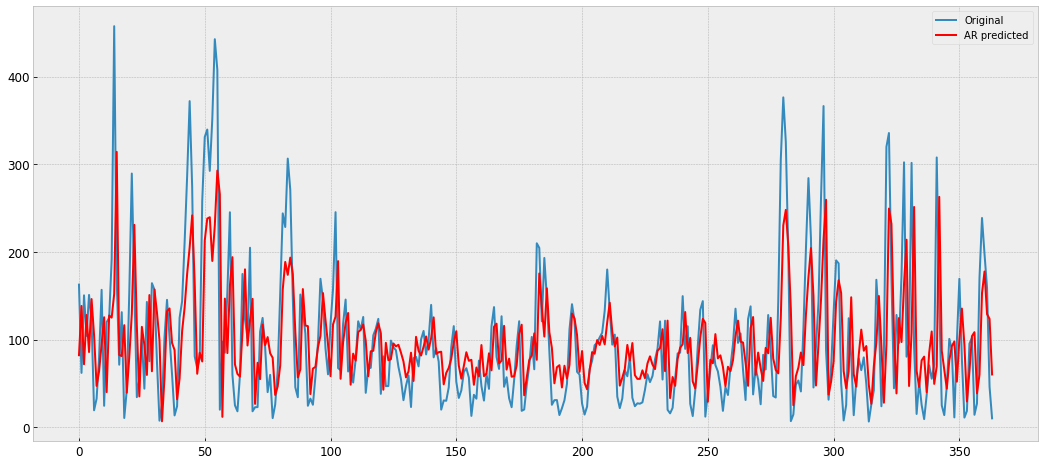

In [29]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
plt.legend()

### Moving Average (MA)

The Moving Average (MA) method models the next step in the sequence as the average of a window of observations at prior time steps. Parameters of the model:


- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 



In [30]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARMA(temp_train.pollution_today, order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['Moving Average'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['Moving Average'] = yhat.values

100%|██████████| 364/364 [00:15<00:00, 23.60it/s]


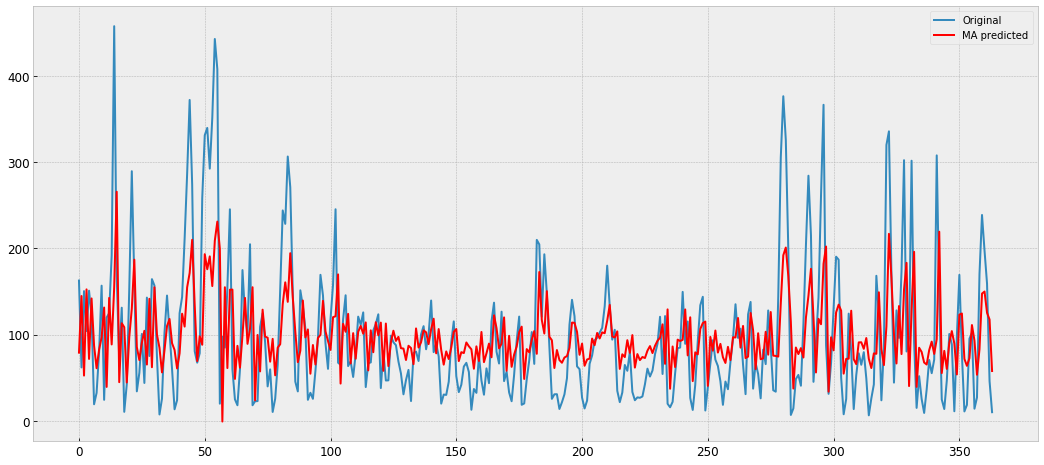

In [31]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='MA predicted')
plt.legend()

### Autoregressive Moving Average (ARMA)

This method will basically join the previous two `AR` and `MA`. Model parameters will be the sum of the two.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 



In [32]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARMA(temp_train.pollution_today, order=(1, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['Autoregressive Moving Average'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['Autoregressive Moving Average'] = yhat.values

100%|██████████| 364/364 [00:55<00:00,  6.58it/s]


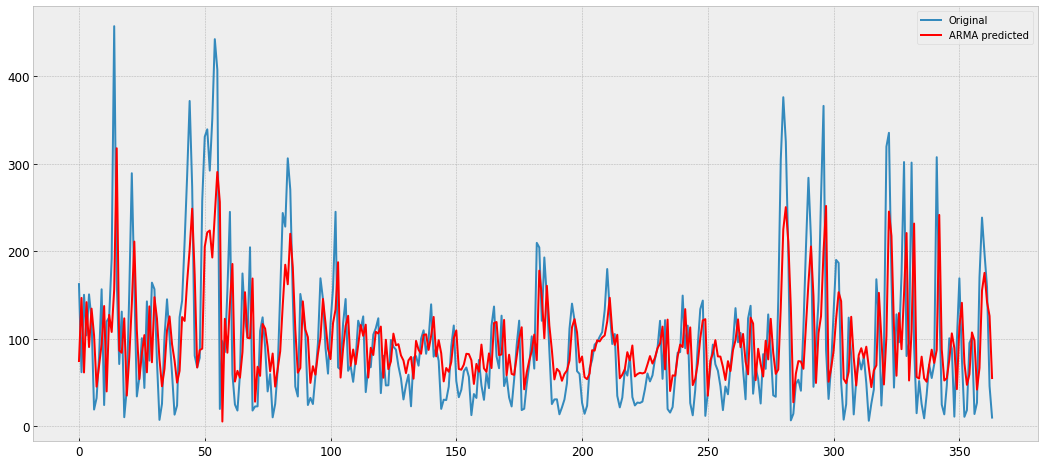

In [33]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='ARMA predicted')
plt.legend()

### Autoregressive integrated moving average (ARIMA) 

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Tuning ARIMA parameters**

Non stationarity series will require level of differencing (d) >0 in ARIMA
Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [34]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(1,0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 364/364 [00:16<00:00, 21.53it/s]


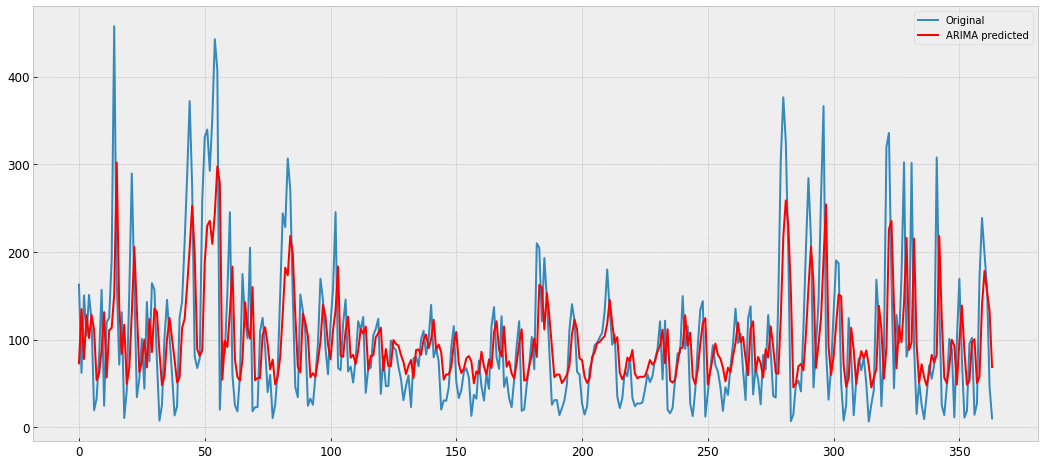

In [35]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted')
plt.legend()

#### Auto ARIMA

In [36]:
#building the model

autoModel = pm.auto_arima(df_training.pollution_today, trace=True, error_action='ignore', suppress_warnings=True,seasonal=False)
autoModel.fit(df_training.pollution_today)

Fit ARIMA: order=(2, 0, 2); AIC=16198.338, BIC=16230.059, Fit time=0.299 seconds
Fit ARIMA: order=(0, 0, 0); AIC=16788.406, BIC=16798.980, Fit time=0.003 seconds
Fit ARIMA: order=(1, 0, 0); AIC=16227.306, BIC=16243.167, Fit time=0.038 seconds
Fit ARIMA: order=(0, 0, 1); AIC=16263.917, BIC=16279.778, Fit time=0.031 seconds
Fit ARIMA: order=(1, 0, 2); AIC=16196.487, BIC=16222.921, Fit time=0.187 seconds
Fit ARIMA: order=(1, 0, 1); AIC=16194.487, BIC=16215.635, Fit time=0.121 seconds
Fit ARIMA: order=(2, 0, 1); AIC=16196.487, BIC=16222.921, Fit time=0.201 seconds
Total fit time: 0.884 seconds


ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=True,
      transparams=True, trend=None, with_intercept=True)

In [37]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(df_test.pollution_today, yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 364/364 [00:55<00:00,  6.51it/s]


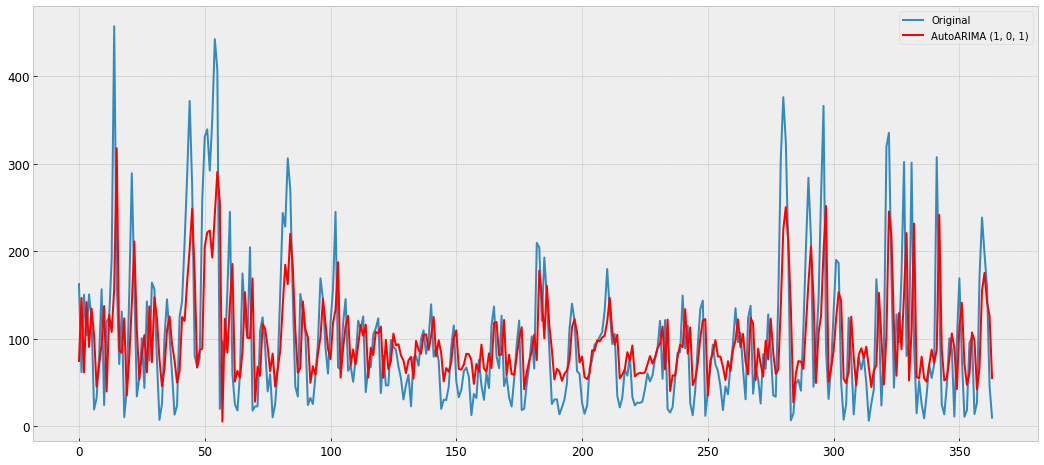

In [38]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='AutoARIMA {0}'.format(order))
plt.legend()

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [39]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution_today, order=(1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 364/364 [00:15<00:00, 23.79it/s]


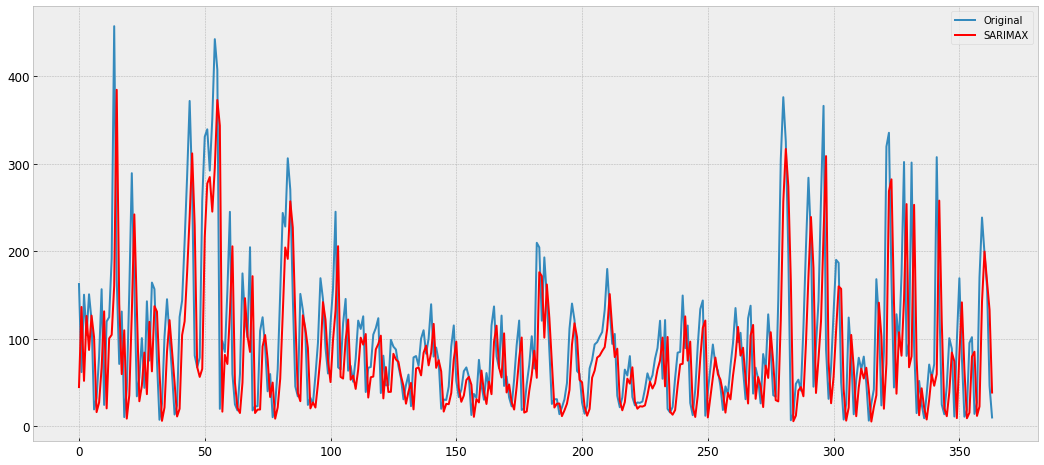

In [40]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
plt.legend()

#### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [41]:
#building the model
autoModel = pm.auto_arima(df_training.pollution_today, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training.pollution_today)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 6); AIC=16199.943, BIC=16242.238, Fit time=2.325 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 6); AIC=16788.406, BIC=16798.980, Fit time=0.025 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 6); AIC=16229.161, BIC=16250.309, Fit time=0.226 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 6); AIC=16265.917, BIC=16287.064, Fit time=0.544 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 6); AIC=16200.349, BIC=16237.357, Fit time=0.564 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 6); AIC=16203.879, BIC=16251.461, Fit time=1.644 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 6); AIC=16200.355, BIC=16237.364, Fit time=0.582 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 2, 6); AIC=16203.861, BIC=16251.443, Fit time=1.975 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 6); AIC=16198.453, BIC=16230.175, Fit time=0.235 seconds
Fit ARIMA: order=(1

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 6), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

In [42]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution_today, order=order, seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = yhat.values

100%|██████████| 364/364 [00:27<00:00, 13.20it/s]


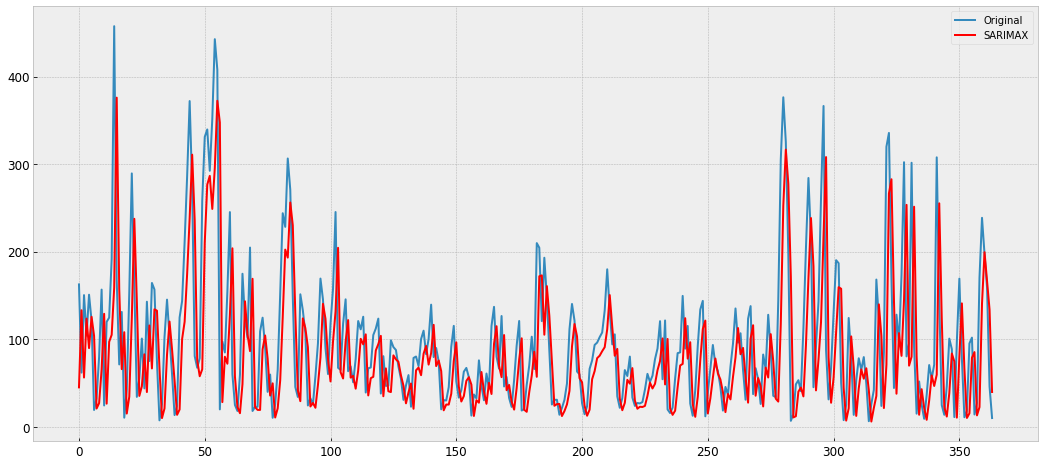

In [43]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
plt.legend()

### Prophet

Prophet is a model released by [facebook](https://github.com/facebook/prophet). Is essentially a curve fitting approach, very similar in spirit to how BSTS models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.


In [44]:
#Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(columns={'pollution_today': 'y'})  # old method  
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'pollution_today': 'y'})  # old method  
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [45]:
prophet = Prophet(
    growth='linear', 
    seasonality_mode='multiplicative',
    holidays_prior_scale=20, 
    daily_seasonality=False, 
    weekly_seasonality=False, 
    yearly_seasonality=False
    ).add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=55
    ).add_seasonality(
        name='daily',
        period=1,
        fourier_order=15
    ).add_seasonality(
        name='weekly',
        period=7,
        fourier_order=25
    ).add_seasonality(
        name='yearly',
        period=365.25,
        fourier_order=20
    ).add_seasonality(
        name='quarterly',
        period=365.25/4,
        fourier_order=55
    ).add_country_holidays(country_name='China')

In [46]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(df_test.pollution_today, yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

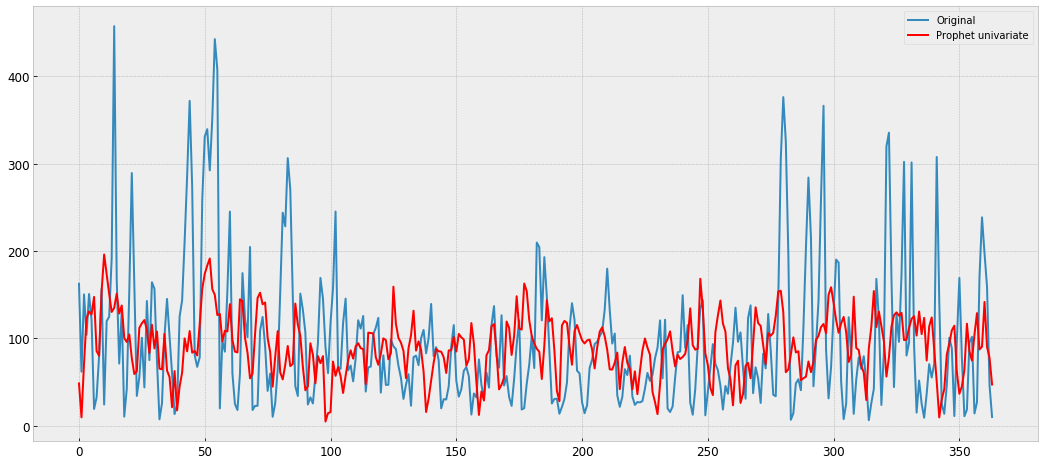

In [47]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.yhat,color='red',label='Prophet univariate')
plt.legend()

## Multivariate time series forecasting

In [48]:
## ADD time features to our model
def create_time_features(df,target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'],axis=1)
    if target:
        y = df[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [49]:
X_train_df, y_train = create_time_features(df_training, target='pollution_today')
X_test_df, y_test = create_time_features(df_test, target='pollution_today')
scaler = StandardScaler() 
scaler.fit(X_train_df) #No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)  
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

### Linear models

#### Bayesian regression

In [50]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['BayesianRidge'] = yhat

#### Lasso

In [51]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lasso'] = yhat

### Tree models

#### Randomforest

In [52]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Randomforest'] = yhat

#### XGBoost

In [53]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train,
       verbose=False) # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['XGBoost'] = yhat

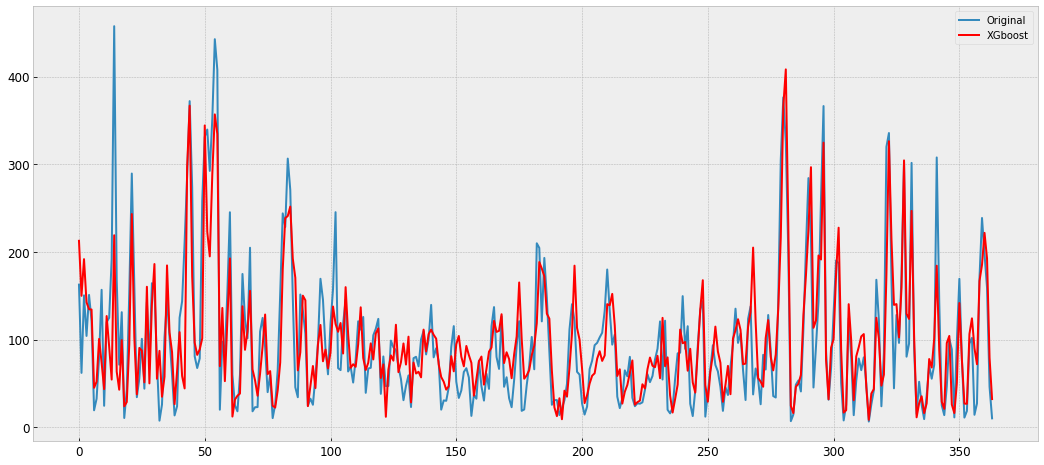

In [54]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat,color='red',label='XGboost')
plt.legend()

#### Lightgbm

A tree gradient boosting model by [microsoft](https://github.com/microsoft/LightGBM) 

In [55]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train,y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lightgbm'] = yhat

### Support vector machines

Explain multiple kernels balbla

In [56]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['SVM RBF'] = yhat

### Nearest neighbors

In [57]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Kneighbors'] = yhat

### Prophet multivariate

In [58]:
prophet = Prophet(
    growth='linear', 
    seasonality_mode='multiplicative',
    daily_seasonality=True, 
    ).add_country_holidays(country_name='China')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [59]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet multivariate'] = yhat.yhat.values

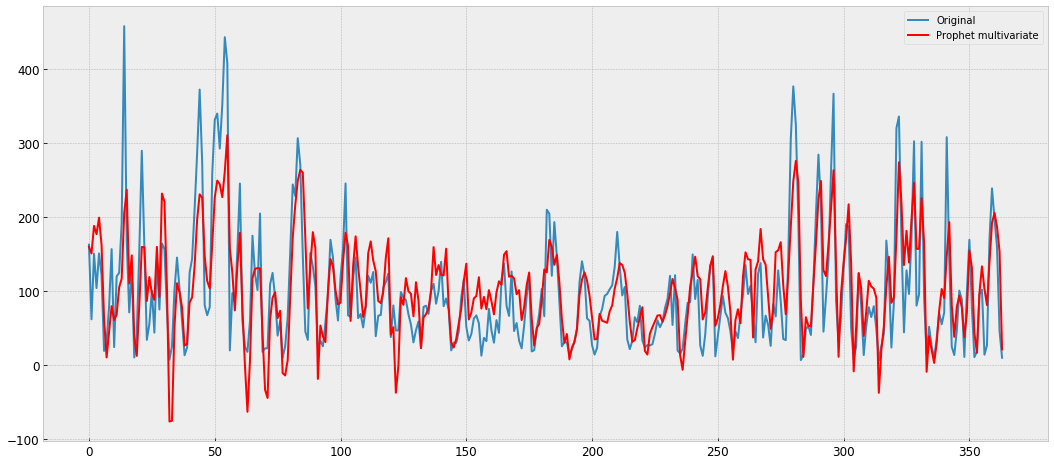

In [60]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.yhat,color='red',label='Prophet multivariate')
plt.legend()

### Deep learning

#### Tensorlfow LSTM

LSTM are a special type of neural network architecture, you can read more on this [here](https://www.tensorflow.org/guide/keras/rnn)

We will be trying a LSTM model for our benchmark but we will need to reshape our data to provide the network a window of previous samples (past days data) for each y target value. Find the code here

In [61]:
#For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
def window_data(X,Y,window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)
        
#Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w,y_w = window_data(X_w,y_w,window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

#Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [62]:
dropout=0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

# simple_lstm_model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],return_sequences=True,dropout=dropout),
#     tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],return_sequences=True,dropout=dropout),
#     tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],return_sequences=False,dropout=dropout),
#     tf.keras.layers.Dense(1)
# ])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") #Support for tensorboard tracking!
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [63]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data, validation_steps=50)#,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - 7s 37ms/step - loss: 52.4208 - val_loss: 45.1437
Epoch 2/5
200/200 [==============================] - 5s 24ms/step - loss: 35.8340 - val_loss: 34.7314
Epoch 3/5
200/200 [==============================] - 5s 24ms/step - loss: 30.2143 - val_loss: 30.8895
Epoch 4/5
200/200 [==============================] - 5s 27ms/step - loss: 27.3898 - val_loss: 29.3854
Epoch 5/5
200/200 [==============================] - 7s 33ms/step - loss: 25.0873 - val_loss: 32.1245


In [64]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1,-1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test,yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

#### DeepAR

[DeepAR](https://arxiv.org/pdf/1704.04110.pdf) is a deep learning architecture released by amazon 

In [65]:
features = ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'pollution_yesterday', 'hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'sin_day', 'cos_day', 'dayofmonth', 'weekofyear']

scaler = StandardScaler() 
scaler.fit(X_train) #No cheating, never scale on the training+test!
df_training[features] = scaler.transform(df_training[features])  
df_test[features] = scaler.transform(df_test[features])


training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training.pollution_today,
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="d"
)
test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test.pollution_today,
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="d"
)

In [66]:
estimator = DeepAREstimator(freq="d",
                            prediction_length=1
                            , context_length=30,
                            trainer=Trainer(epochs=5))

predictor = estimator.train(training_data=training_data)





forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)


INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 22.09it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[0] Elapsed time 2.265 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.731202
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 22.60it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[1] Elapsed time 2.214 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=5.539167
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 21.00it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[2] Elapsed time 2.383 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=5.463747
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 23.32it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[3] Elapsed time 2.146 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=5.374336
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 24.19i

In [67]:
yhat = forecasts[0].samples.reshape(1,-1)[0]
resultsDict['DeepAR'] = evaluate(y_test,yhat)
predictionsDict['DeepAR'] = yhat

#  Results

## Evaluation Metrics

There are many measures that can be used to analyze the performance of our prediction so we will be using the top 4 most used metrics for time series forecasting. Each of this metrics are different from the others in the way the test our predictions so don't expect a model to perform best in all metrics. Choosing the right metric for your problem is also a big challenge, this will depend on your forecasting needs.

* [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error)
* [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)
* [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
* [R2 Coefficient of determination (r2)](https://en.wikipedia.org/wiki/Coefficient_of_determination)

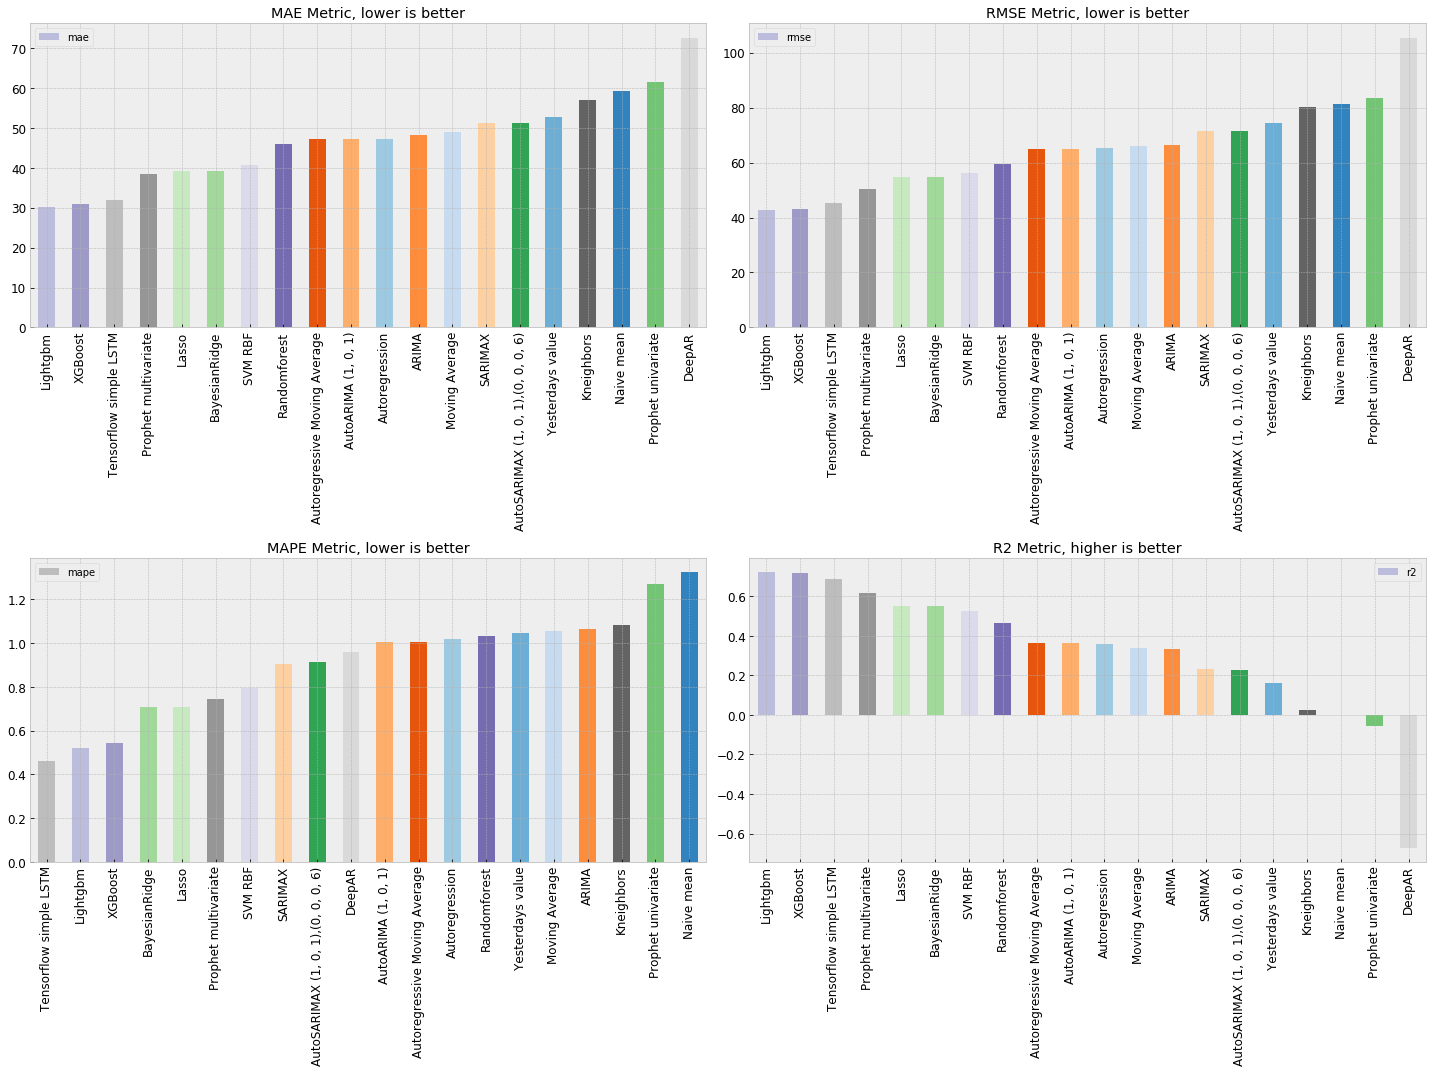

In [68]:
bar_metrics(resultsDict)

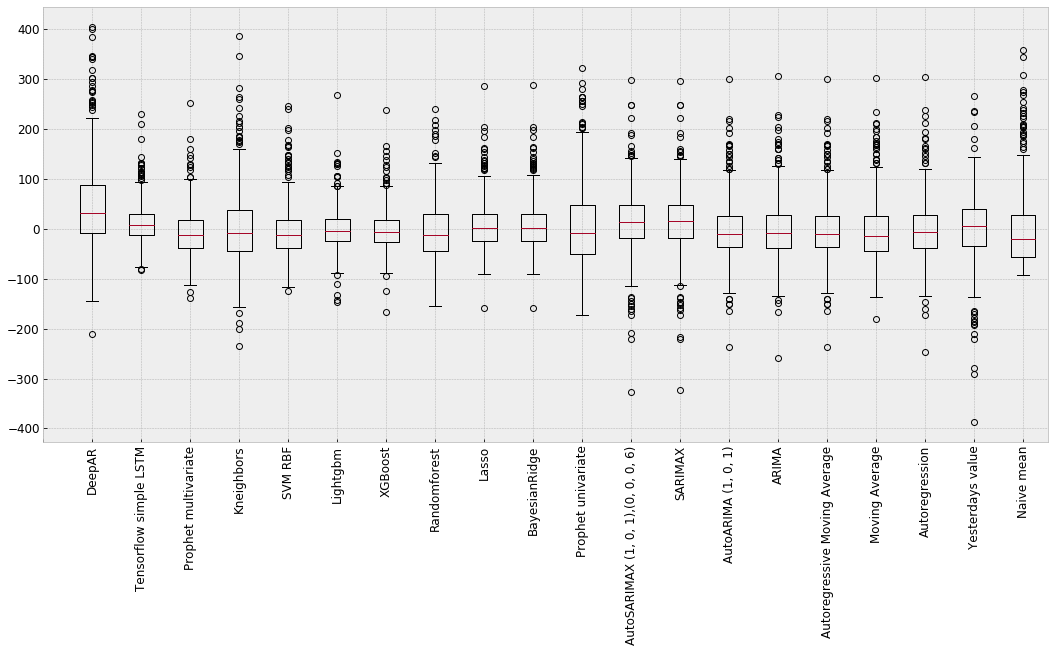

In [69]:
residuals = [df_test.pollution_today.values - predictionsDict[u] for u in predictionsDict.keys()]
residuals.reverse()
plt.boxplot(residuals)
ticks = list(predictionsDict.keys())
ticks.reverse()
ticks = [''] + ticks
rang = range(0,len(ticks))
plt.xticks(rang, ticks,rotation='vertical')
pass


# Conclusion

First and most obvious lesson from this tutorial should be the importance of extra features to describe your time series. We have seen how most of the models that took use of the extra data outperforms traditional statistics for univariate time series. Is also worth mentioning the importance of doing an extensive analysis of our series to detect stationarity or special seasonalities that may require us to apply some transform to the series and will probably determine our model selection. Blind selection of models should never be the case and we should always aim for a good understanding of our series.

For some more in detail discussion about the result, I personally was not surprise to see the tree models come on top as they are one of the most used models right now thanks for their easy use and great performance. I was surprise to see our LSTM model come up with such close scores to the tree models with such a little dataset, deep learning methods are known for their good performance but only if enourmous datasets are provided.

There are still some things you could do to improve your forecasting metrics but we will leave them in the appendix as they are small tweaks that you can apply for almost any model to gain small %.

# Appendix

## Hyperparameter optimization

We have seen models with really low amount of parameters (Auto regression models,Linear models) or with crazy ammount (Trees,Prophet). Some models are more robust to different data types/shapes and dont need any hyperparameter optimization but some other can give you poor results if the parameters are not tunned, we can tune the model parameters to better fit our dataset properties. We can do this manually with pure knowledge about the model but this becames really hard when the model contains a lot of different parameters, this is when hyperparameter optimization comes handy.

Hyperparameter optimization is trying to find the best parameters in an automatic way. We present two methods that are used frequently:

* **Grid search** Brute force method to try all different possible combinations of parameters. Will always find the best combination
* **Bayesian processes** "Brute" force method, optimizes parameter search by using gausian processes to model each parameter distribution and don't go over all the possible values. Really nice library for python https://github.com/fmfn/BayesianOptimization, this method will not always find the best combination of parameters

We provide 1 example for each method

### Grid search - SVM

With grid search we can use the handy sklearn implementation

In [70]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF GRID SEARCH'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['SVM RBF GRID SEARCH'] = yhat

In [71]:
increase = 1 - (resultsDict['SVM RBF GRID SEARCH']['rmse']/resultsDict['SVM RBF']['rmse'])
print(f"Grid search Tunned SVM is {increase*100}% better than the SVM with default parameters")

Grid search Tunned SVM is 10.159715482199394% better than the SVM with default parameters


### Bayesian processes - Xgboost

In [72]:
def rms(y_actual,y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3,15),
    'min_samples_leaf': (1,4),
    'min_samples_split': (2,10),
}
 
def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):
 
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
 
    clf = RandomForestRegressor(n_estimators=n_estimators, 
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)
    
    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))
 
optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [73]:
optimizer.maximize(
    init_points=3,
    n_iter=20,
    acq='ei'
)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.5467   |  8.004    |  3.161    |  2.001    |  3.093e+0 |
|  2        | -0.5101   |  4.761    |  1.277    |  3.49     |  3.521e+0 |
|  3        | -0.5456   |  7.761    |  2.616    |  5.354    |  6.884e+0 |
|  4        | -0.5281   |  5.877    |  2.285    |  7.815    |  4.881e+0 |
|  5        | -0.4625   |  3.0      |  1.0      |  2.0      |  1e+04    |
|  6        | -0.46     |  3.315    |  3.21     |  7.499    |  3.52e+03 |
|  7        | -0.5072   |  4.552    |  3.428    |  9.609    |  3.52e+03 |
|  8        | -0.4606   |  3.054    |  3.6      |  9.411    |  3.428e+0 |
|  9        | -0.5438   |  7.721    |  3.312    |  5.012    |  9.85e+03 |
|  10       | -0.553    |  14.93    |  2.808    |  5.007    |  1.126e+0 |
|  11       | -0.546    |  7.527    |  1.902    |  5.322    |  8.327e+0 |
|  12       | -0.5424   |  7.21     | 

In [74]:
params = optimizer.max['params']

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])
params['min_samples_leaf']= int(params['min_samples_leaf'])
params['min_samples_split']= int(params['min_samples_split'])

#Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_rf = RandomForestRegressor(**params)
tunned_rf.fit(X_train, y_train) # Change verbose to True if you want to see it train

yhat = tunned_rf.predict(X_test)
resultsDict['Randomforest tunned'] = evaluate(y_test, yhat)

In [75]:
increase = 1 - (resultsDict['Randomforest tunned']['rmse']/resultsDict['Randomforest']['rmse'])
print(f"Bayesian optimized Randomforest is {increase*100}% better than the Randomforest with default parameters")

Bayesian optimized Randomforest is 10.593018169782265% better than the Randomforest with default parameters


## Ensembling

Ensembling refers to combine multiple models to achieve a better performance, most of the time this only makes sense when models have similar performance but predict values differently so we try to get the best of each model.

We will pick our 3 top performing models and look at the correlation of their residuals, the less correlated the better

In [76]:
models = ['Tensorflow simple LSTM',
 'Lightgbm',
 'XGBoost']
resis = pd.DataFrame(data={k: df_test.pollution_today.values - v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


We can see how both tree models are a bit similar ~0.87 but quite different from the Deep Learning model with corr ~0.7. In this case it would really make sense to ensemble the methods and see how they behave. The most reasonable combinations to try would be

* XGboost + Tensorflow
* XGBoost + Lightgbm
* Lightgbm + Tensorflow
* XGBoost + Lightgbm + Tensorflow

We will just sum the predictions of each model with similar weights (0.5 if two models, 0.333 if three)

In [77]:
predictionsDict['EnsembleXG+LIGHT'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm'])/2
resultsDict['EnsembleXG+LIGHT'] = evaluate(df_test.pollution_today.values,predictionsDict['EnsembleXG+LIGHT'])

predictionsDict['EnsembleXG+LIGHT+TF'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/3
resultsDict['EnsembleXG+LIGHT+TF'] = evaluate(df_test.pollution_today.values,predictionsDict['EnsembleXG+LIGHT+TF'])

predictionsDict['EnsembleLIGHT+TF'] = (predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleLIGHT+TF'] = evaluate(df_test.pollution_today.values,predictionsDict['EnsembleLIGHT+TF'])

predictionsDict['EnsembleXG+TF'] = (predictionsDict['XGBoost']+ predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleXG+TF'] = evaluate(df_test.pollution_today.values,predictionsDict['EnsembleXG+TF'])

In [78]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

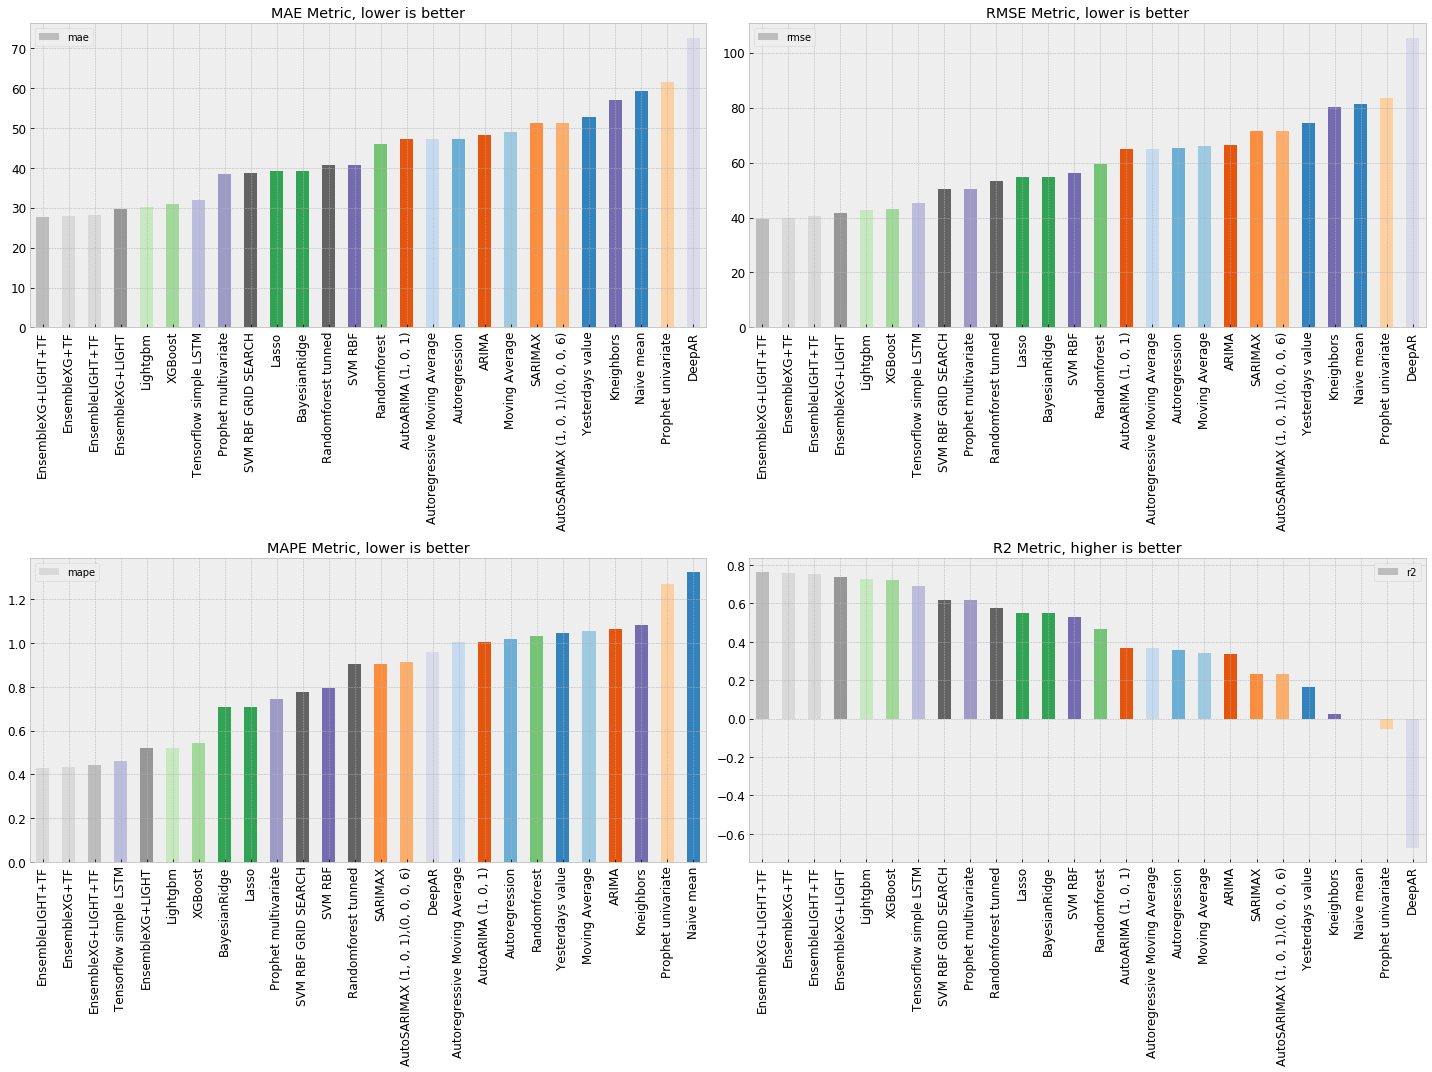

In [79]:
from utils.plots import bar_metrics
bar_metrics(resultsDict)

In [80]:
%load_ext autoreload

Looks like we get even better performance!

## Feature importance

Some models allow for for native feature importance algorithms but I personally like the library [SHAP](https://github.com/slundberg/shap) that provides a game theory approach to measure how each feature affects our forecast. 

Here is an example on how to use SHAP for our Lightgbm model

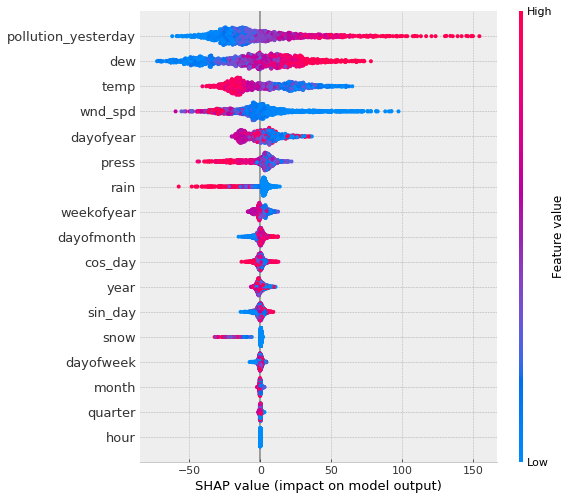

In [81]:
explainer = shap.TreeExplainer(lightGBM)
shap_values = explainer.shap_values(X_train_df)
shap.summary_plot(shap_values, X_train_df)

In [82]:
df = pd.DataFrame.from_dict(resultsDict)
df.to_csv("results/results_summary.csv",index=False)

In [83]:
df.to_html("results/results_summary.html")

# Possible improvements

* Parameter tunned lightgbm and xgboost and redo the ensemble with Tensorflow


# Additional resources and literature
## Papers

|| |
| - | - |
| Adhikari, R., & Agrawal, R. K. (2013). An introductory study on time series modeling and forecasting.|[[1]](https://arxiv.org/ftp/arxiv/papers/1302/1302.6613.pdf)|

https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/